In [54]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import math
from math import sqrt
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
!pip install pmdarima
from pmdarima import auto_arima
from pandas import DataFrame
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
# df here is the HDFC_6m dataset
# I will be working on this dataset for the entire predictions

df = pd.read_csv(r"/Users/aditibanjare/Downloads/HDFCBANK.NS(6).csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-20,1528.449951,1528.500000,1500.099976,1509.000000,1491.656494,7598923
1,2022-01-21,1500.000000,1529.800049,1485.599976,1521.599976,1504.111694,5768847
2,2022-01-24,1509.949951,1521.250000,1467.550049,1486.650024,1469.563354,5934254
3,2022-01-25,1458.650024,1495.000000,1444.000000,1488.050049,1470.947266,6797124
4,2022-01-27,1450.000000,1485.000000,1435.000000,1474.949951,1457.997803,14308919
...,...,...,...,...,...,...,...
118,2022-07-13,1390.000000,1394.199951,1354.250000,1357.849976,1357.849976,7972805
119,2022-07-14,1362.000000,1372.650024,1349.250000,1351.050049,1351.050049,5186205
120,2022-07-15,1353.000000,1364.900024,1346.800049,1362.050049,1362.050049,6797823
121,2022-07-18,1348.000000,1366.099976,1342.050049,1347.550049,1347.550049,10166110


I will firstly list down the steps that I am going to follow - 

1. Exploratory Data Analysis - This involves - 
   1. Redundant data removal
   2. Conversion of ‘Date’ Attribute to dateTime and 
   3. Use of the grouping function to group ‘Date’ and ‘Close’
2. Stationarity Test
   1. ACF and PACF plots 
   2. Dicky Fuller Test
3. Auto ARIMA
   1. Computing Optimum values of p,d and q

In [3]:
# checking for null values in df dataset

df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
# since there are no null values in the df data set we can move forward

In [6]:
# Conversion of ‘Date’ Attribute to dateTime for df dataset
# This makes the dataet compatible of ARIMA model

type(df.Date[0])

str

In [7]:
df["Date"] = pd.to_datetime(df["Date"], format = '%Y-%m-%d')

In [8]:
type(df.Date[0])

pandas._libs.tslibs.timestamps.Timestamp

In [11]:
# Use of the grouping function to group ‘Date’ and ‘Close’
# Used to group only the relevant attributes from the dataset

df_new = df.groupby('Date')[['Close']].mean()
df_new

,Close
Date,
2022-01-20,1509.000000
2022-01-21,1521.599976
2022-01-24,1486.650024
2022-01-25,1488.050049
2022-01-27,1474.949951
...,...
2022-07-13,1357.849976
2022-07-14,1351.050049
2022-07-15,1362.050049


In [12]:
# ACF and PACF plots
# A data is said to be stationary if the mean, variance and autocorrelation structure do not show any difference over time

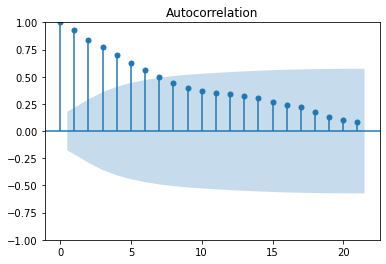

In [27]:
plot_acf(df_new['Close'])
pyplot.show()

/Users/aditibanjare/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


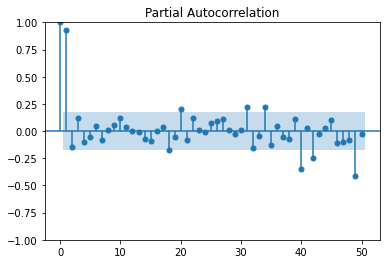

In [30]:
plot_pacf(df_new['Close'], lags = 50)
pyplot.show()

In [14]:
# Dicky Fuller Test
# For a dataset to be stationary, p-value must be less than 5%
# We assume that it is not so

In [36]:
result = adfuller(df_new['Close'])
print(result)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('#Lags Used : %f'% result[2])
print('Number of Observation Used: %f' % (result[3]))
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

(-2.4338817667127874, 0.13240094754288856, 1, 121, {'1%': -3.485585145896754, '5%': -2.885738566292665, '10%': -2.5796759080663887}, 1037.460668494948)
ADF Statistic: -2.433882
p-value: 0.132401
#Lags Used : 1.000000
Number of Observation Used: 121.000000
Critical Values:
	1%: -3.486
	5%: -2.886
	10%: -2.580


In [37]:
df_new['Close First Difference'] = df_new['Close'] - df_new['Close'].shift(1)
df_new['Close'].shift(1)

Date
2022-01-20            NaN
2022-01-21    1509.000000
2022-01-24    1521.599976
2022-01-25    1486.650024
2022-01-27    1488.050049
                 ...     
2022-07-13    1391.800049
2022-07-14    1357.849976
2022-07-15    1351.050049
2022-07-18    1362.050049
2022-07-19    1347.550049
Name: Close, Length: 123, dtype: float64

In [38]:
result1 = adfuller(df_new['Close First Difference'].dropna())
print(result1)
print('ADF Statistic: %f' % result1[0])
print('p-value: %f' % result1[1])
print('#Lags Used : %f'% result1[2])
print('Number of Observation Used: %f' % (result1[3]))
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

(-10.038257989233212, 1.5202337664458792e-17, 0, 121, {'1%': -3.485585145896754, '5%': -2.885738566292665, '10%': -2.5796759080663887}, 1032.0100113659519)
ADF Statistic: -10.038258
p-value: 0.000000
#Lags Used : 0.000000
Number of Observation Used: 121.000000
Critical Values:
	1%: -3.486
	5%: -2.886
	10%: -2.580


Text(0, 0.5, 'Price')

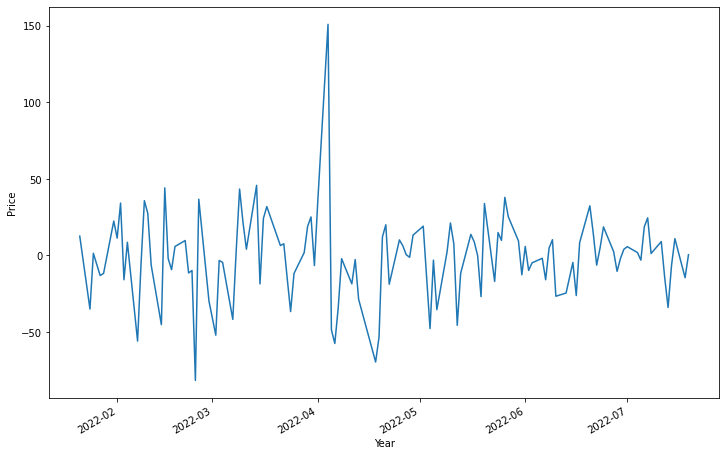

In [35]:
adfuller(df_new['Close First Difference'].dropna())
df_new['Close First Difference'].plot(figsize = (12,8))
plt.xlabel("Year")
plt.ylabel("Price")

In [39]:
# After the above steps the dataset has become stationary, so we move forward 
# Auto ARIMA, Computing Optimum values of p,d and q for the best results of forecasting for the ARIMA model.
# Model whose AIC value is the lowest

In [55]:
stepwise_fit = auto_arima(df_new['Close'],trace = True, suppress_warnings = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1166.935, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1163.597, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1164.735, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1164.472, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1161.866, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1165.755, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.494 seconds


/Users/aditibanjare/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/aditibanjare/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/aditibanjare/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/aditibanjare/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  123
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -579.933
Date:                Thu, 21 Jul 2022   AIC                           1161.866
Time:                        04:01:04   BIC                           1164.670
Sample:                             0   HQIC                          1163.005
                                - 123                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       787.7961     50.414     15.626      0.000     688.986     886.606
Ljung-Box (L1) (Q):                   0.88   Jarque-Bera (JB):               207.83
Prob(Q):                              0.35   Pr

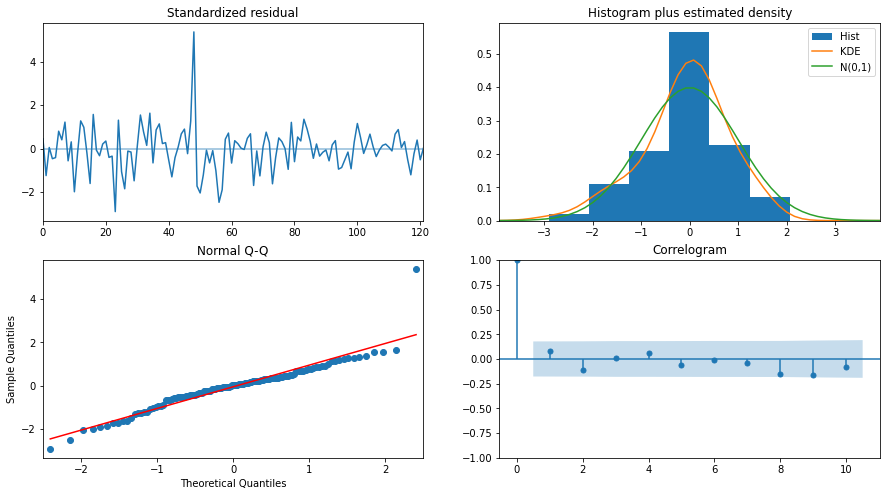

In [56]:
print(stepwise_fit.summary())
stepwise_fit.plot_diagnostics(figsize = (15,8))
plt.show()

1. Top left - Uniform variance and fluctuates around a mean of zero

2. Top Right - Normal distribution with a mean of zero

3. Bottom left - Significant deviations indicate a skewed distribution

4. Bottom Right - The residual errors are not autocorrelated